## CLT

This script correctly find the weights such that the network learns the deterministic map $\zeta_{n+1} = \frac{1}{\sqrt{2}} (\zeta_n^1 + \zeta_n^2)$. Let's choose to consider the uniform distribution, and use MSE loss.

We attempt to find the network mapping of cumulants ('the statistical model') in this Gaussian approximation, and compare it to the analytical 'true' cumulant transformation that we know that the CLT RG decimation induces. Cumulants should transform individually in a way that is consistent with Fischer paper's framework under these weights. Where nonlinearities are used, this notebook uses the Fischer approach of only considering the network as propagating Gaussian statistics.

In [27]:
import numpy as np
import torch
from torch import nn
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F
from scipy.stats import norm
from openpyxl import load_workbook


import matplotlib as mpl
mpl.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times"],
    "mathtext.fontset": "cm",
    "legend.frameon": False,
    # "font.size": 12,
    # "axes.labelsize": 12,
    # "xtick.labelsize": 12,
    # "ytick.labelsize": 12,
    # "legend.fontsize": 12,
})

# Set seed for reproducibility
SEED = 45
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

torch.set_default_dtype(torch.float64)

# Data

## Generate Data

Here we consider a uniform distribution.

First define some useful functions to calculate cumulants.

In [28]:
def cumulant_extraction(data):
    """
    Compute the first four cumulants for a 1D array.
    Parameters:
        data: np.ndarray of shape (N,)
    Returns:
        A dictionary with cumulants k1 to k4
    """
    mean = np.mean(data)                          # κ1
    centered = data - mean

    var = np.mean(centered**2)                    # κ2
    third = np.mean(centered**3)                  # κ3
    fourth_raw = np.mean(centered**4)
    fourth = fourth_raw - 3 * var**2              # κ4

    return {
        'kappa1': mean,
        'kappa2': var,
        'kappa3': third,
        'kappa4': fourth
    }

def expected_cumulant_evolution(data):
    """Input: data is a dictionary of input cumulants
    This function scales each cumulant according to expected transform from the Jona-Lasinio paper."""
    
    scaled_cumulants = {}
    for key, value in data.items():
        # Extract the cumulant order (k) from the key string 'kappa{k}'
        k = int(key[-1])
        
        # Calculate the scaling factor
        scaling_factor = 2 ** (1 - k / 2)
        
        # Scale the cumulant value
        scaled_cumulants[key] = value * scaling_factor
    
    return scaled_cumulants

import itertools
def symmetrise_tensor(tensor):
    """
    Symmetrise a tensor over all its axes.
    Args:
        tensor (np.ndarray): A tensor of shape (d, d, ..., d)
    Returns:
        sym_tensor (np.ndarray): Symmetrised version of the input tensor.
    """
    order = tensor.ndim
    perms = list(itertools.permutations(range(order)))
    sym_tensor = sum(np.transpose(tensor, axes=perm) for perm in perms)
    sym_tensor /= len(perms)
    return sym_tensor

def cumulant_extraction_multidim(data):
    """
    Compute the first four cumulants for a 2D array.
    Parameters:
        data: np.ndarray of shape (N, 2)
    Returns:
        A dictionary with cumulants k1 to k4
    """
    N, d = data.shape
    
    # Mean vector (κ1)
    mean = np.mean(data, axis=0)  # Shape: (2,)
    
    # Centered data
    centered = data - mean  # Shape: (N, 2)
    
    # Covariance matrix (κ2)
    " Using einsum() to find the covariance is implicitly assuming that there is already some level of correlation"
    " Between the two dimensions. If the data is uncorrelated, this will yield a covariance matrix with off-diagonal elements close to zero."
    " But the data should be two independent columns initially, with a diagonal covariance - and correlations will emerge as you propagate them."
    
    " We shouldn't manually diagonalise the covariance."
    
    # covariance = np.einsum('ni,nj->ij', centered, centered) / N  # Shape: (2, 2)
    # covariance = np.diag(np.var(data, axis=0))  # Shape: (2, 2)

    # κ2: Covariance matrix
    covariance = np.einsum('ni,nj->ij', centered, centered) / N  # Shape: (2, 2)
    
    # Third-order cumulant tensor (κ3)
    G3_raw = np.einsum('ni,nj,nk->ijk', centered, centered, centered) / N  # Shape: (2, 2, 2)
    G3 = symmetrise_tensor(G3_raw)
    
    # Fourth-order cumulant tensor (κ4)
    G4_raw = np.einsum('ni,nj,nk,nl->ijkl', centered, centered, centered, centered) / N  # Shape: (2, 2, 2, 2)
    
    # # Applying the correction for the fourth cumulant
    # kappa4 = G4_raw - 3 * np.einsum('ij,kl->ijkl', covariance, covariance) # only valid for jointly gaussian data
    
    # Full Gaussian correction for fourth cumulant
    cov = covariance
    term1 = np.einsum('ij,kl->ijkl', cov, cov)
    term2 = np.einsum('ik,jl->ijkl', cov, cov)
    term3 = np.einsum('il,jk->ijkl', cov, cov)
    kappa4_raw = G4_raw - (term1 + term2 + term3)
    kappa4 = symmetrise_tensor(kappa4_raw)  # Shape: (2, 2, 2, 2)
    
    # Package the results in a dictionary
    cumulants = {
        'kappa1': torch.tensor(mean, dtype=torch.float64),                     # Shape: (2,)
        'kappa2': torch.tensor(covariance, dtype=torch.float64),               # Shape: (2, 2)
        'kappa3': torch.tensor(G3, dtype=torch.float64),                       # Shape: (2, 2, 2)
        'kappa4': torch.tensor(kappa4, dtype=torch.float64)                        # Shape: (2, 2, 2, 2)
    }
    
    return cumulants

# Find input cumulants:
def find_input_cumulants(dataset):


    # Extract inputs and labels from dataset
    xs = np.array([x.numpy() for x, _ in dataset])  # shape (N, 2)
    
    # Compute column-wise cumulants
    col1 = cumulant_extraction(xs[:, 0])
    col2 = cumulant_extraction(xs[:, 1])
    avg_cumulants = {k: 0.5 * (col1[k] + col2[k]) for k in col1}

    # Full multivariate cumulants
    z_dict = cumulant_extraction_multidim(xs)


    # # Of each column:
    # first_col = []
    # second_col = []
    # labels = []
    # for i in range(len(data_samples)):
    #     x, y = data_samples[i]
    #     first_col.append(x[0].item())
    #     second_col.append(x[1].item())
    #     labels.append(y.item())

    # first_col = np.array(first_col)  # Shape: (n_train, )
    # second_col = np.array(second_col)  # Shape: (n_train, )
    # labels = np.array(labels)  # Shape: (n_train, )

    # # Find average input cumulants for each column
    # col1 = cumulant_extraction(first_col)
    # print("\nInitial Empirical Cumulants (first col):")
    # for k, v in col1.items():
    #     print(f"{k}: {v}")

    # col2 = cumulant_extraction(second_col)
    # print("\nInitial Empirical Cumulants (second col):")
    # for k, v in col2.items():
    #     print(f"{k}: {v}")
    # print("\n")

    # # Find average input cumulants across the two columns
    # avg_cumulants = {}
    # for k in col1.keys():
    #     avg_cumulants[k] = 0.5 * (col1[k] + col2[k])

    # print("Average Empirical Cumulants (across both input columns):")
    # for k, v in avg_cumulants.items():
    #     print(f"{k}: {v}")


    # # # Compute the cumulants for the input data (multivariate)
    # input_array = data_samples.samples
    # z_dict = cumulant_extraction_multidim(input_array)

    # print("\nCumulants of Input Data:")
    # for k, v in z_dict.items():
    #     print(f"{k}: shape = {v.shape}, value = {v}")

    return avg_cumulants, z_dict

# Compute output cumulants
def find_pred_output_cumulants(dataset):

    #  # Of each column:
    # first_col = []
    # second_col = []
    # labels = []
    # for i in range(len(data_samples)):
    #     x, y = data_samples[i]
    #     first_col.append(x[0].item())
    #     second_col.append(x[1].item())
    #     labels.append(y.item())

    # first_col = np.array(first_col)  # Shape: (n_train, )
    # second_col = np.array(second_col)  # Shape: (n_train, )
    # labels = np.array(labels)  # Shape: (n_train, )

    # # Jona-Lasinio transform, averaged
    # col1 = cumulant_extraction(first_col)
    # col2 = cumulant_extraction(second_col)
    # expected_cumulants_col1 = expected_cumulant_evolution(col1)
    # expected_cumulants_col2 = expected_cumulant_evolution(col2)
    # avg_evolved_cumulants = {}
    # for k in expected_cumulants_col1.keys():
    #     avg_evolved_cumulants[k] = 0.5 * (expected_cumulants_col1[k] + expected_cumulants_col2[k])

    # print("\nAverage expected evolved cumulants (Jona-Lasinio), across both columns:\n")
    # for k, v in avg_evolved_cumulants.items():
    #     print(f"{k}: {v}")

    # # Ground truth labels
    # ground_truth_cumulants = cumulant_extraction(labels)
    # print("\nCumulants of the ground truth labels:")
    # for k, v in ground_truth_cumulants.items():
    #     print(f"{k}: {v}")
    # print("-------------------\n")



    xs = np.array([x.numpy() for x, _ in dataset])
    ys = np.array([y.item() for _, y in dataset])

    col1 = cumulant_extraction(xs[:, 0])
    col2 = cumulant_extraction(xs[:, 1])

    evolved1 = expected_cumulant_evolution(col1)
    evolved2 = expected_cumulant_evolution(col2)
    avg_evolved_cumulants = {k: 0.5 * (evolved1[k] + evolved2[k]) for k in evolved1}

    ground_truth_cumulants = cumulant_extraction(ys)

    return avg_evolved_cumulants, ground_truth_cumulants


## This section is now defunct

In [29]:
# # Sample pairs of points from a 1D uniform distribution
# def adjust_samples_to_match_cumulants(y, target_cumulants):
#     """Adjust distribution to match desired cumulants (preserve mean)."""
#     y_centered = y - np.mean(y)
#     y_scaled = y_centered / np.std(y)

#     # Use Gram-Charlier-like polynomial correction (not perfect, but practical)
#     skew_target = target_cumulants['kappa3'] / (target_cumulants['kappa2'] ** 1.5)
#     kurt_target = target_cumulants['kappa4'] / (target_cumulants['kappa2'] ** 2)


#     # Fit using a 3rd/4th order polynomial transform to match shape (approximate)
#     corrected = y_scaled \
#         + 0.5 * skew_target * (y_scaled**2 - 1) \
#         + (1/24) * kurt_target * (y_scaled**3 - 3*y_scaled)

#     # Rescale to target mean and std
#     corrected = corrected * np.sqrt(target_cumulants['kappa2']) + target_cumulants['kappa1']
#     return corrected

# def get_data(number):
#     x = np.random.uniform(low=-0.5, high=0.5, size=(number, 2))
#     decimated_x = np.sum(x, axis=1) / np.sqrt(2) # array shape (n, 2) -> (n, 1)

#     first_col = x[:, 0]
#     second_col = x[:, 1]

#     # Find input cumulants
#     col1 = cumulant_extraction(first_col)
#     col2 = cumulant_extraction(second_col)
#     avg_cumulants = {}
#     for k in col1.keys():
#         avg_cumulants[k] = 0.5 * (col1[k] + col2[k])
#     expected_y_cumulants = expected_cumulant_evolution(avg_cumulants)

#     decimated_x_corrected = adjust_samples_to_match_cumulants(decimated_x, expected_y_cumulants)
#     return x, decimated_x_corrected

# # Check
# test_in, test_out = get_data(1000)
# for i in range(len(test_in[:, 0])):
#     if test_out[i] != np.sum(test_in[i]) / np.sqrt(2):
#         print("Error in cumulant matching")
#         break

# test_out_cumulants = cumulant_extraction(test_out)


## Generate Data - Correct

In [ ]:
# Sample pairs of points from a 1D uniform distribution
def get_data_uniform(number):
    x = np.random.uniform(low=0, high=1, size=(number, 2))
    decimated_x = np.sum(x, axis=1) / np.sqrt(2) # array shape (n, 2) -> (n, 1)
    return x, decimated_x

def get_data_gaussian(number): # centred unit gaussian
    x = np.random.normal(loc=0, scale=1.0, size=(number, 2)) # loc is mean, scale is stdev (not variance)
    decimated_x = np.sum(x, axis=1) / np.sqrt(2) # array shape (n, 2) -> (n, 1)
    return x, decimated_x

def get_data_gaussian_shifted(number): # unit gaussian, mean shifted to 1/sqrt(2)
    x = np.random.normal(loc=1/(np.sqrt(2)), scale=1.0, size=(number, 2)) # loc is mean, scale is stdev (not variance)
    decimated_x = np.sum(x, axis=1) / np.sqrt(2) # array shape (n, 2) -> (n, 1)
    return x, decimated_x

def get_data_gaussian_varied(number, var):
    x = np.random.normal(loc=0, scale=np.sqrt(var), size=(number, 2)) # loc is mean, scale is stdev (not variance)
    decimated_x = np.sum(x, axis=1) / np.sqrt(2) # array shape (n, 2) -> (n, 1)
    return x, decimated_x

class gaussian_data(Dataset):
    def __init__(self, n_samples):
        self.samples, self.true_samples = get_data_gaussian(n_samples)

    def __len__(self):
        return self.samples.shape[0]

    def __getitem__(self, idx):
        return (
            torch.tensor(self.samples[idx], dtype=torch.float64),
            torch.tensor(self.true_samples[idx], dtype=torch.float64)
        )

class gaussian_data_vary_std(Dataset):
    def __init__(self, n_samples, var):
        self.samples, self.true_samples = get_data_gaussian_varied(n_samples, var)

    def __len__(self):
        return self.samples.shape[0]

    def __getitem__(self, idx):
        return (
            torch.tensor(self.samples[idx], dtype=torch.float64),
            torch.tensor(self.true_samples[idx], dtype=torch.float64)
        )

class gaussian_data_shifted_mean(Dataset):
    def __init__(self, n_samples):
        self.samples, self.true_samples = get_data_gaussian_shifted(n_samples)

    def __len__(self):
        return self.samples.shape[0]

    def __getitem__(self, idx):
        return (
            torch.tensor(self.samples[idx], dtype=torch.float64),
            torch.tensor(self.true_samples[idx], dtype=torch.float64)
        )

class uniform_data(Dataset):
    def __init__(self, n_samples):
        self.samples, self.true_samples = get_data_uniform(n_samples)

    def __len__(self):
        return self.samples.shape[0]

    def __getitem__(self, idx):
        return (
            torch.tensor(self.samples[idx], dtype=torch.float64),
            torch.tensor(self.true_samples[idx], dtype=torch.float64)
        )

n_train = int(1e6)
n_test = int(1e6)
# var = 1

train_samples = gaussian_data(n_train)
trainloader = DataLoader(train_samples, batch_size=64, shuffle=True)
test_samples = uniform_data(n_test)
testloader = DataLoader(test_samples, batch_size=64, shuffle=False)

# Understanding statistical source of prediction errors// Identifying reasonable sample sizes

## Discrepancy between ground truth and JL expected scaled cumulants

In [31]:
# sample_sizes = [10**3, 5*10**3, 10**4, 5*10**4, 10**5, 5*10**5, 10**6, 5*10**6, 10**7]
# n_trials = 5  # number of seeds


# # var = 1
# errors_kappa4 = []
# errors_kappa3 = []
# errors_kappa2 = []

# trial_data = []

# for N in sample_sizes:
#     deviations_k4 = []
#     deviations_k3 = []
#     deviations_k2 = []
    
#     for trial in range(n_trials):

#         test_samples = uniform_data(N)
#         test_inputs, _ = find_input_cumulants(test_samples)
#         JL_pred_cumulants, ground_truth_cumulants = find_pred_output_cumulants(test_samples)

#         # Compare — e.g., deviation of κ₄
#         k4_pred = JL_pred_cumulants['kappa4']
#         k4_gt = ground_truth_cumulants['kappa4']

#         k3_pred = JL_pred_cumulants['kappa3']
#         k3_gt = ground_truth_cumulants['kappa3']

#         k2_pred = JL_pred_cumulants['kappa2']
#         k2_gt = ground_truth_cumulants['kappa2']

#         # Compute deviations
#         deviation_k4 = np.abs(k4_pred - k4_gt)
#         deviation_k3 = np.abs(k3_pred - k3_gt)
#         deviation_k2 = np.abs(k2_pred - k2_gt)

#         deviations_k4.append(deviation_k4)
#         deviations_k3.append(deviation_k3)
#         deviations_k2.append(deviation_k2)

#         # Save this trial's data
#         trial_data.append([N, trial + 1, deviation_k2, deviation_k3, deviation_k4])

#     # Store average deviation for this N
#     errors_kappa4.append(np.mean(deviations_k4))
#     errors_kappa3.append(np.mean(deviations_k3))
#     errors_kappa2.append(np.mean(deviations_k2))



In [32]:
# plt.plot(sample_sizes, errors_kappa2, marker='o', label='empirical deviations - k2')
# plt.plot(sample_sizes, errors_kappa3, marker='s', label='empirical deviations - k3')
# plt.plot(sample_sizes, errors_kappa4, marker='x', label='empirical deviations - k4')
# expected = [np.sqrt(24 / N) for N in sample_sizes]
# plt.plot(sample_sizes, expected, '--', label="√(24/N)")
# plt.xscale('log')
# plt.yscale('log')
# plt.xlabel("Sample size (N)")
# plt.ylabel("Mean deviations")
# plt.title("Discrepancy vs. Sample Size")
# plt.legend()
# plt.grid(True)

# slope, intercept = np.polyfit(np.log10(sample_sizes), np.log10(errors_kappa4), 1)
# print("Estimated convergence rate:", slope)

### Saving to csv

In [33]:
# import csv

# # Combine sample sizes and corresponding errors into rows
# rows = zip(sample_sizes, errors_kappa4)

# # Specify output file name
# output_file = "kappa4_samplesize_gaussian.csv"

# # Write to CSV with UTF-8 encoding
# with open(output_file, mode='w', newline='', encoding='utf-8') as file:
#     writer = csv.writer(file)
#     writer.writerow(["Sample Size (N)", "Mean Deviation in κ4"])  # Header
#     for row in rows:
#         writer.writerow(row)

# print(f"Saved to: {output_file}")



In [34]:
# import csv

# # Save summary (mean deviations)
# # =============================
# summary_file = "cumulant_deviations_summary.csv"

# with open(summary_file, mode='w', newline='', encoding='utf-8') as file:
#     writer = csv.writer(file)
#     writer.writerow([
#         "Sample Size (N)",
#         "Mean Deviation in κ2 (Variance)",
#         "Mean Deviation in κ3 (Skewness)",
#         "Mean Deviation in κ4 (Kurtosis)"
#     ])
#     for N, d2, d3, d4 in zip(sample_sizes, errors_kappa2, errors_kappa3, errors_kappa4):
#         writer.writerow([N, d2, d3, d4])

# print(f"Saved summary to: {summary_file}")


# # =============================
# # Save detailed trial data
# # =============================
# detailed_file = "cumulant_deviations_trials.csv"

# with open(detailed_file, mode='w', newline='', encoding='utf-8') as file:
#     writer = csv.writer(file)
#     writer.writerow([
#         "Sample Size (N)",
#         "Trial Number",
#         "Deviation in κ2",
#         "Deviation in κ3",
#         "Deviation in κ4"
#     ])
#     writer.writerows(trial_data)

# print(f"Saved detailed trial data to: {detailed_file}")

## Off-Diagonal L2 Norm Decay for higher order cumulants

In [35]:
# sample_sizes = [10**3, 5*10**3, 10**4, 5*10**4, 10**5, 5*10**5, 10**6, 5*10**6, 10**7]
# n_trials = 5  # number of seeds

# # Per-sample-size trial data
# trial_data_k2 = []
# trial_data_k3 = []
# trial_data_k4 = []

# # Per-sample-size mean (for main trend line)
# mean_offdiag_k2 = []
# mean_offdiag_k3 = []
# mean_offdiag_k4 = []

# for N in sample_sizes:
#     deviations_k2, deviations_k3, deviations_k4 = [], [], []

#     for _ in range(n_trials):
#         test_samples = uniform_data(N)
#         cumulants = cumulant_extraction_multidim(test_samples.samples)

#         # κ2: remove diagonal
#         k2 = cumulants['kappa2'].numpy()
#         off_k2 = k2 - np.diag(np.diag(k2))
#         deviations_k2.append(np.sum(off_k2**2))

#         # κ3: mask fully diagonal terms (i=j=k)
#         k3 = cumulants['kappa3'].numpy()
#         mask3 = np.ones_like(k3, dtype=bool)
#         for i in range(k3.shape[0]):
#             mask3[i, i, i] = False
#         deviations_k3.append(np.sum(k3[mask3]**2))

#         # κ4: mask fully diagonal terms (i=j=k=l)
#         k4 = cumulants['kappa4'].numpy()
#         mask4 = np.ones_like(k4, dtype=bool)
#         for i in range(k4.shape[0]):
#             mask4[i, i, i, i] = False
#         deviations_k4.append(np.sum(k4[mask4]**2))

#     # Save per-trial data
#     trial_data_k2.append(deviations_k2)
#     trial_data_k3.append(deviations_k3)
#     trial_data_k4.append(deviations_k4)

#     # Save averages
#     mean_offdiag_k2.append(np.mean(deviations_k2))
#     mean_offdiag_k3.append(np.mean(deviations_k3))
#     mean_offdiag_k4.append(np.mean(deviations_k4))


In [36]:
# plt.figure(figsize=(8, 6))

# # Plot average L2 norms for κ₂, κ₃, and κ₄
# plt.plot(sample_sizes, mean_offdiag_k2, 'o-', label=r'$\kappa_2$')
# plt.plot(sample_sizes, mean_offdiag_k3, 's-', label=r'$\kappa_3$')
# plt.plot(sample_sizes, mean_offdiag_k4, '^-', label=r'$\kappa_4$')

# # Log scale
# plt.xscale('log')
# plt.yscale('log')

# # Labels and title
# plt.xlabel('Sample size (N)')
# plt.ylabel('Mean off-diagonal L2 norm')
# plt.title('Off-diagonal Discrepancy vs. Sample Size')
# plt.grid(True, which='both', linestyle='--', linewidth=0.5)
# plt.legend()

# plt.tight_layout()
# plt.show()

In [37]:
# import csv

# output_file = "offdiag_deviations_L2norm.csv"

# with open(output_file, mode='w', newline='', encoding='utf-8') as file:
#     writer = csv.writer(file)
    
#     # Write header
#     header = ['Sample Size', 'Cumulant']
#     header += [f'Trial {i+1}' for i in range(n_trials)]
#     header += ['Mean']
#     writer.writerow(header)

#     # Helper to write one cumulant's data
#     def write_cumulant_rows(sample_sizes, trial_data, mean_data, cumulant_label):
#         for i, N in enumerate(sample_sizes):
#             row = [N, cumulant_label]
#             row.extend(trial_data[i])
#             row.append(mean_data[i])
#             writer.writerow(row)

#     # Write data for each cumulant
#     write_cumulant_rows(sample_sizes, trial_data_k2, mean_offdiag_k2, 'kappa2')
#     write_cumulant_rows(sample_sizes, trial_data_k3, mean_offdiag_k3, 'kappa3')
#     write_cumulant_rows(sample_sizes, trial_data_k4, mean_offdiag_k4, 'kappa4')

# print(f"Saved to: {output_file}")


### Off diag L1 norm

In [38]:
# # Per-sample-size trial data
# trial_data_k2_L1norm = []
# trial_data_k3_L1norm = []
# trial_data_k4_L1norm = []

# # Per-sample-size mean (for main trend line)
# mean_offdiag_k2_L1norm = []
# mean_offdiag_k3_L1norm = []
# mean_offdiag_k4_L1norm = []

# for N in sample_sizes:
#     deviations_k2, deviations_k3, deviations_k4 = [], [], []

#     for _ in range(n_trials):
#         test_samples = uniform_data(N)
#         cumulants = cumulant_extraction_multidim(test_samples.samples)

#         # κ2: remove diagonal
#         k2 = cumulants['kappa2'].numpy()
#         off_k2 = k2 - np.diag(np.diag(k2))
#         deviations_k2.append(np.sum(np.abs(off_k2)))  # L1 norm

#         # κ3: mask fully diagonal terms (i=j=k)
#         k3 = cumulants['kappa3'].numpy()
#         mask3 = np.ones_like(k3, dtype=bool)
#         for i in range(k3.shape[0]):
#             mask3[i, i, i] = False
#         deviations_k3.append(np.sum(np.abs(k3[mask3])))  # L1 norm

#         # κ4: mask fully diagonal terms (i=j=k=l)
#         k4 = cumulants['kappa4'].numpy()
#         mask4 = np.ones_like(k4, dtype=bool)
#         for i in range(k4.shape[0]):
#             mask4[i, i, i, i] = False
#         deviations_k4.append(np.sum(np.abs(k4[mask4])))  # L1 norm

#     # Save per-trial data
#     trial_data_k2_L1norm.append(deviations_k2)
#     trial_data_k3_L1norm.append(deviations_k3)
#     trial_data_k4_L1norm.append(deviations_k4)

#     # Save averages
#     mean_offdiag_k2_L1norm.append(np.mean(deviations_k2))
#     mean_offdiag_k3_L1norm.append(np.mean(deviations_k3))
#     mean_offdiag_k4_L1norm.append(np.mean(deviations_k4))

In [39]:
# plt.figure(figsize=(8, 6))

# # Plot average L1 norms for κ₂, κ₃, and κ₄
# plt.plot(sample_sizes, mean_offdiag_k2_L1norm, 'o-', label=r'$\kappa_2$')
# plt.plot(sample_sizes, mean_offdiag_k3_L1norm, 's-', label=r'$\kappa_3$')
# plt.plot(sample_sizes, mean_offdiag_k4_L1norm, '^-', label=r'$\kappa_4$')

# # Log scale
# plt.xscale('log')
# plt.yscale('log')

# # Labels and title
# plt.xlabel('Sample size (N)')
# plt.ylabel('Mean off-diagonal L1 norm')  # <-- updated from L2 to L1
# plt.title('Off-diagonal Discrepancy vs. Sample Size (L1 Norm)')
# plt.grid(True, which='both', linestyle='--', linewidth=0.5)
# plt.legend()

# plt.tight_layout()
# plt.show()

In [40]:
# # Define CSV filename
# output_file = "offdiag_cumulant_L1norms_uniform_task.csv"

# # Open and write to CSV
# with open(output_file, mode='w', newline='') as file:
#     writer = csv.writer(file)
    
#     # Header row
#     n_trials = len(trial_data_k2_L1norm[0])
#     header = ['SampleSize', 'K2_mean', 'K3_mean', 'K4_mean']
#     header += [f'K2_trial_{i+1}' for i in range(n_trials)]
#     header += [f'K3_trial_{i+1}' for i in range(n_trials)]
#     header += [f'K4_trial_{i+1}' for i in range(n_trials)]
#     writer.writerow(header)

#     # Write data per sample size
#     for idx, N in enumerate(sample_sizes):
#         row = [N,
#                mean_offdiag_k2_L1norm[idx],
#                mean_offdiag_k3_L1norm[idx],
#                mean_offdiag_k4_L1norm[idx]]
#         row += trial_data_k2_L1norm[idx]
#         row += trial_data_k3_L1norm[idx]
#         row += trial_data_k4_L1norm[idx]
#         writer.writerow(row)

# print(f"✅ Saved to: {output_file}")


# Define Models

### Network Model

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# Define quadratic activation function
alpha = 0.5
class QuadraticActivation(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, z):
        return z + alpha*(z ** 2)

# Define leaky Relu slope
slope = 0.1

# Define model, L=1, N=10, sigma = 0.75
class oneDNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        " 1 hidden layer with a quadratic nonlinearity (so can reuse Fischer analysis directly):"
        self.non_linear_activ = nn.Sequential(
            nn.Linear(2, 2, bias=False),
            # QuadraticActivation(),
            nn.LeakyReLU(negative_slope=slope),
            nn.Linear(2, 1, bias=False)

            # nn.Linear(50, 50, bias=True),
            # QuadraticActivation(),
            # nn.Linear(50, 50, bias=True),
            # QuadraticActivation(),
            # nn.Linear(50, 50, bias=True),
            # QuadraticActivation(),
        )
        self._initialize_weights()
    
    def forward(self, x):
        logits = self.non_linear_activ(x)
        return logits
    
    def _initialize_weights(self):
        for i, m in enumerate(self.non_linear_activ):
            if isinstance(m, nn.Linear):
                if i == 0:
                    nn.init.normal_(m.weight, mean=0, std=np.sqrt(0.75/2))
                else:
                    nn.init.normal_(m.weight, mean=0, std=np.sqrt(0.75/2))
                # nn.init.normal_(m.bias, mean=0, std=np.sqrt(0.75))
                # nn.init.constant_(m.bias, 0)

Using cpu device


### Statistical Model // Cumulant Propagation

In [42]:
def propagate_affine_gaussian(mean, covariance, W, b=None):
    """ Adjusted for this task
     Propagate the first two cumulants through an affine transformation."""
    mean = mean.to(torch.float64)
    covariance = covariance.to(torch.float64)
    W = W.to(torch.float64)

#    print(f"\n-----------\nStarting propagation across affine layer")
#     print(f"Test - printing the shapes of the inputs:")
#     print(f" Mean shape: {mean.shape}")
#     print(f" Covariance shape: {covariance.shape}")
#     print(f" W shape: {W.shape}") 
    # if b is not None:
    #     print(f" b shape: {b.shape}")
    
    # if mean.ndim == 1:  # Ensure it's a column vector for multiplication
    #     mean = mean.unsqueeze(1)  # Shape: [n, 1]


    # if mean.shape[0] != W.shape[1]:
    #     raise ValueError(f"Size mismatch: Mean size {mean.shape} is incompatible with weight matrix size {W.shape}.")

    if b is not None:
        b = b.to(torch.float64)
        if b.ndim == 1:
            b = b.unsqueeze(1)
        mu_Z = (W @ mean).squeeze() + b.squeeze()
    else:
        mu_Z = (W @ mean).squeeze()
    #     mu_Z = W @ mean.T + b
    # else:
    #     mu_Z = W @ mean.T
    cov_Z = W @ covariance @ W.T

    # print(f"\n Output mean shape: {mu_Z.shape}")
    # print(f" Output covariance shape: {cov_Z.shape}")
    # print(f"Propagated across affine layer complete \n--------------------------\n")

    return mu_Z, cov_Z

def propagate_affine_higher(g3, g4, W):
    """ Adjusted for this task
     Propagate the first two cumulants through an affine transformation."""
    g3 = g3.to(torch.float64)
    g4 = g4.to(torch.float64)
    W = W.to(torch.float64)

    # print(f"\n-----------\nStarting propagation across affine layer")
    # print(f"Test - printing the shapes of the inputs:")
    # print(f" Mean shape: {g3.shape}")
    # print(f" Covariance shape: {g4.shape}")
    # print(f" W shape: {W.shape}")
    
    # Propagate 3rd order cumulant
    g3_z = torch.einsum('ri,sj,tk,ijk->rst', W, W, W, g3)

    # Propagate 4th order cumulant
    g4_z = torch.einsum('ri,sj,tk,ul,ijkl->rstu', W, W, W, W, g4)

    # print(f"Output cumulant shapes:")
    # print(f"  g3_z shape: {g3_z.shape}")
    # print(f"  g4_z shape: {g4_z.shape}")
    # print(f"Propagation across affine layer complete\n--------------------------\n")

    return g3_z, g4_z

def propagate_quadratic_gaussian(mean, covariance):
    """ Propagate cumulants through a quadratic activation function
    Assume the Fischer Gaussian approx, ie this is for wide hidden layers - so only first two cumulants get propagated """

    # # assuming cumulants higher than second order vanish - which they do for this input distribution
    # diagonal_cov = torch.diagonal(covariance, dim1=-2, dim2=-1).unsqueeze(-1)
    # mu_y = mean + alpha * (mean ** 2 + diagonal_cov)

    # cov_y = covariance + 2 * alpha * covariance * (mean.unsqueeze(-1) + mean.unsqueeze(-2)) \
    #     + 2 * alpha**2 * (covariance @ covariance) \
    #     + 4 * alpha**2 * mean.unsqueeze(-1) * covariance * mean.unsqueeze(-2)

    # return mu_y, cov_y    

    diagonal_cov = torch.diagonal(covariance, dim1=0, dim2=1)  # Shape: [n]
    
    # Mean propagation (remains a 1D vector of size [n])
    mu_y = mean + alpha * (mean ** 2 + diagonal_cov)
    
    # Covariance propagation (remains a 2D matrix of size [n, n])
    mean_outer = mean.unsqueeze(1) * mean.unsqueeze(0)  # Shape: [n, n]

    cov_y = covariance + 2 * alpha * (covariance * (mean.unsqueeze(0) + mean.unsqueeze(1))) \
            + 2 * alpha**2 * (covariance @ covariance) \
            + 4 * alpha**2 * mean_outer * covariance

    return mu_y, cov_y

def propagate_full_gaussian_only(cumulants, weights, biases=None):
    """ Propagates input cumulants through the network (that uses quadratic activation)
    Capable of handling varying numbers of layers (we just extract the weights and biases from the model).
    
     This function only propagates the first two cumulants - ie we truncate, effectively assume all higher ones = 0 """

    # mu_list = []
    # cov_list = []
    # for i in range(len(mean_values)):
    #     mu = mean_values[i].to(torch.float64)
    #     cov = covariances[i].to(torch.float64)

    # Extract cumulants
    mu = cumulants['kappa1']
    cov = cumulants['kappa2']
    # G3 = cumulants['kappa3']
    # G4 = cumulants['kappa4']


    for layer_idx in range(len(weights)):
        W = weights[layer_idx].to(torch.float64)
        if biases is not None:
            bi =  biases[layer_idx].to(torch.float64)

        mu = mu.reshape(-1) # Flatten mu to a row vector - this is a quirk of pytorch matrix multiplication
        if biases is not None:
            mu, cov = propagate_affine_gaussian(mu, cov, W, bi)
            # print(f" Propagated across affine, WITH BIASES!: \n mu: {mu} \n cov: {cov}")
        else:
            mu, cov = propagate_affine_gaussian(mu, cov, W)
            # print(f"Propagated across affine: \n mu: {mu} \n cov: {cov}")
        if layer_idx < len(weights) - 1:
            mu, cov = propagate_quadratic_gaussian(mu, cov)
            # print(f"Propagated across quadratic: \n mu: {mu} \n cov: {cov}")
    
    return mu, cov

def propagate_full_linear(cumulants, weights, biases=None):
    """Propagates input cumulants through a purely linear network.
    No nonlinear activation functions are used.
    Gaussian approximation is irrelevant here as we aren't using nonlinearities."""
    
    mu, cov, g3, g4 = cumulants['kappa1'], cumulants['kappa2'], cumulants['kappa3'], cumulants['kappa4']

    for layer_idx in range(len(weights)):
        W = weights[layer_idx].to(torch.float64)
        if biases is not None:
            b =  biases[layer_idx].to(torch.float64)

        mu = mu.reshape(-1) # Flatten mu to a row vector - this is a quirk of pytorch matrix multiplication
        if biases is not None:
            mu, cov = propagate_affine_gaussian(mu, cov, W, b)
            # print(f" Propagated across affine: \n mu: {mu} \n cov: {cov}")
            g3, g4 = propagate_affine_higher(g3, g4, W)
            # print(f" Propagated across affine: \n g3: {g3} \n g4: {g4}")
        else:
            mu, cov = propagate_affine_gaussian(mu, cov, W)
            # print(f"Propagated across affine: \n mu: {mu} \n cov: {cov}")
            g3, g4 = propagate_affine_higher(g3, g4, W)
            # print(f" Propagated across affine: \n g3: {g3} \n g4: {g4}")

    return mu, cov, g3, g4



#### Higher Orders
The below code was an attempt at using higher order cumulants in the input layer, couldn't get it to work though.

Separated out the code for clarity.

In [43]:
def propagate_affine_with_higher(mean, covariance, G3, G4, W, b=None):
    """ Adjusted for this task
     Propagate the first four cumulants through an affine transformation."""
    mean = mean.to(torch.float64)
    covariance = covariance.to(torch.float64)
    W = W.to(torch.float64)
    if b is not None:
        b = b.to(torch.float64)
        mu_Z = W @ mean.T + b.unsqueeze(1)

    else:
        mu_Z = W @ mean.T
    cov_Z = W @ covariance @ W.T

    G3_z = np.einsum('ia,jb,kc,abc->ijk', W, W, W, G3)
    G4_z = np.einsum('ia,jb,kc,ld,abcd->ijkl', W, W, W, W, G4)

    G3_z = torch.tensor(G3_z, dtype=torch.float64)
    G4_z = torch.tensor(G4_z, dtype=torch.float64)


    return mu_Z.T, cov_Z, G3_z, G4_z

def propagate_quadratic_with_higher(mean, covariance, G3, G4):
    """ Propagate cumulants through a quadratic activation function
     This is for the input layer - so need to consider how all higher order cumulants 
        contribute to the mean/cov of postactivations, not just propagating the first two only across the activation 
        
    Mean should be a vector of shape (n,) otherwise the higher order contribution to the cov will throw errors"""
    
    # mean
    diagonal_cov = torch.diagonal(covariance, dim1=-2, dim2=-1).unsqueeze(-1)
    mu_y = mean + alpha * (mean ** 2 + diagonal_cov)

    # cov
    cov_y = covariance + 2 * alpha * covariance * (mean.unsqueeze(-1) + mean.unsqueeze(-2)) \
        + 2 * alpha**2 * (covariance @ covariance) \
        + 4 * alpha**2 * mean.unsqueeze(-1) * covariance * mean.unsqueeze(-2)

    # Find the higher order cumulant contribution
    n = mean.shape[0] 

    term1 = alpha * (1 + 2 * alpha * mean.unsqueeze(-1)) * G3  # Shape: (n, n, n)
    term1 = term1.sum(dim=2)  # Sum over the last axis to get a matrix of shape (n, n)

    term2 = alpha * (1 + 2 * alpha * mean.unsqueeze(-2)) * G3  # Shape: (n, n, n)
    term2 = term2.sum(dim=0)  # Sum over the first axis to get a matrix of shape (n, n)

    term3 = alpha**2 * G4.sum(dim=(0, 2))  # Sum over axes 1, 3 (ie picking the first i,j to sum over) for a matrix of shape (n, n)

    # Combine all terms
    higher_order_term = term1 + term2 + term3
    cov_y += higher_order_term


    return mu_y, cov_y

def propagate_full_with_higher(cumulants, weights, biases=None):
    """ Propagates input cumulants through the network (that uses quadratic activation)
    Capable of handling varying numbers of layers (we just extract the weights and biases from the model).
    
     This function considers higher cumulants when propagating across input layer, but 
        truncates for rest of network (ie assumes higher cumulants vanish) """

    # Extract cumulants
    mu = cumulants['kappa1']
    cov = cumulants['kappa2']
    G3 = cumulants['kappa3']
    G4 = cumulants['kappa4']

    # Initial affine layer - propagate all cumulants
    W = weights[0].to(torch.float64)
    if biases is not None:
        b = biases[0].to(torch.float64)
    mu = mu.view(-1)  # Flatten mu to a row vector (PyTorch quirk)
    
    if biases is not None:
        mu, cov, G3, G4 = propagate_affine_with_higher(mu, cov, G3, G4, W, b)
    else:
        mu, cov, G3, G4 = propagate_affine_with_higher(mu, cov, G3, G4, W)

    # First nonlinearity - propagate all cumulants with propagate_quadratic_with_higher()
    mu, cov = propagate_quadratic_with_higher(mu, cov, G3, G4)

    
    for layer_idx in range(1, len(weights)): # start from second layer
        W = weights[layer_idx].to(torch.float64)
        if biases is not None:
            b = biases[layer_idx].to(torch.float64)

        # Ensure mu is properly shaped before matrix multiplication
        if mu.dim() == 1:  # If `mu` is a 1D vector
            mu = mu.view(-1)  # Ensure it is flat, (in_features,)
        elif mu.dim() == 2 and mu.size(0) == 1:  # If it's a row vector, reshape it
            mu = mu.squeeze(0)

        if biases is not None:
            mu, cov = propagate_affine_gaussian(mu, cov, W, b)
        else:
            mu, cov = propagate_affine_gaussian(mu, cov, W)
        if layer_idx < len(weights) - 1:
            mu, cov = propagate_quadratic_gaussian(mu, cov)

    
    return mu, cov


# Training

### Training, Plotting Functions

In [44]:
# If want to enforce symmetric weights constraints
@torch.no_grad()
def enforce_weight_constraints(model):
    """
    Enforce symmetry in the first layer (2x2) and equal weights in the second layer (1x2).
    """
    layers = model.non_linear_activ
    layer1 = layers[0]
    layer2 = layers[2]

    # First layer: symmetric 2x2 weights
    if isinstance(layer1, nn.Linear) and layer1.weight.shape == (2, 2):
        W = layer1.weight.data

        # Extract current entries
        a = 0.5 * (W[0, 0] + W[1, 1])  # average of diagonals
        b = 0.5 * (W[0, 1] + W[1, 0])  # average of off-diagonals

        # Construct constrained matrix
        constrained_W = torch.tensor([[a, b],
                                      [b, a]], dtype=W.dtype, device=W.device)

        layer1.weight.data.copy_(constrained_W)

        # Enforce bias vector [b, b]
        if layer1.bias is not None:
            b = layer1.bias.data
            avg_bias = b.mean()
            b.fill_(avg_bias)
            layer1.bias.data.copy_(b)
    
    # Second layer: equal weights (1x2)
    # Need to change this from 1 to 2 if including nonlinearity
    if isinstance(layer2, nn.Linear) and layer2.weight.shape == (1, 2):
        W = layer2.weight.data
        avg_value = W.mean()
        W.fill_(avg_value)
        layer2.weight.data.copy_(W)

@torch.no_grad()
def check_dead_neurons(model, dataloader, threshold=0.99):
    """
    Check for dead neurons in ReLU layers by computing how often their output is zero.

    Args:
        model: the trained model
        dataloader: data loader with input samples
        threshold: fraction of zeros above which a neuron is considered dead

    Returns:
        Dict of dead neuron indices and percentages per layer
    """
    model.eval()
    dead_report = {}
    
    for i, layer in enumerate(model.non_linear_activ):
        if isinstance(layer, nn.Linear):
            continue  # skip linear layers directly
        # if isinstance(layer, nn.ReLU) or isinstance(layer, QuadraticActivation):
        if isinstance(layer, (nn.ReLU, nn.LeakyReLU, QuadraticActivation)):
            # Only apply this for real ReLU-like activations, or Quadratic if you ever extend it
            layer_outputs = []

            for X, _ in dataloader:
                X = X.to(device)
                with torch.no_grad():
                    # Forward until this layer
                    out = X
                    for j in range(i + 1):
                        out = model.non_linear_activ[j](out)
                    layer_outputs.append(out.cpu())

            layer_outputs = torch.cat(layer_outputs, dim=0)
            # zero_mask = (layer_outputs == 0)
            epsilon = 1e-5
            zero_mask = (layer_outputs.abs() < epsilon)

            zero_fraction = zero_mask.sum(dim=0).float() / zero_mask.shape[0]

            dead_neurons = (zero_fraction > threshold).nonzero(as_tuple=True)[0].tolist()
            dead_report[f"Layer {i}"] = {
                "dead_neurons": dead_neurons,
                "fractions": zero_fraction.numpy()
            }

    return dead_report

def train(dataloader, model, loss_fn, optimizer, track_loss=False, track_params=False, symmetry=False):

    size = len(dataloader.dataset)
    model.train()
    loss_steps = []
    loss_values = []
    param_steps = []
    param_changes = []
    step = 0

    if track_params:
        prev_params = {name: param.clone().detach() for  name, param in model.named_parameters()}

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device).unsqueeze(1)

        # Compute prediction error for forward pass on current batch
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if symmetry:
            # 🔧 Enforce symmetry and equal weights
            enforce_weight_constraints(model)

        
        # Track loss
        if track_loss:
            loss_steps.append(step)
            loss_values.append(loss.item()) # this is already a per-batch average loss
        
        # Track parameter changes every 10 steps/batches
        if track_params and step % 10 ==0 and step > 0:
            total_param_change = 0
            for name, param in model.named_parameters():
                param_diff = param.detach() - prev_params[name]
                # total_param_change += torch.norm(param_diff, p=2).item()
                total_param_change += torch.sum(param_diff ** 2).item()  # Direct sum of squared differences
                prev_params[name] = param.clone().detach()
            param_steps.append(step)
            param_changes.append(np.sqrt(total_param_change))

        if batch % 500 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"Current batch: {current:>5d}/{size:>5d}\n  Loss of batch: {loss:>7f}")

        step += 1
    
    return loss_steps, loss_values, param_steps, param_changes


def collect_model_outputs(dataloader, model):
    """
    Performs a single forwards pass, then collects all outputs from the model for the given dataloader and
      stacks them into a 1D numpy array.

    Parameters:
        dataloader (DataLoader): The DataLoader to iterate over.
        model (torch.nn.Module): The trained model whose outputs are to be collected.

    Returns:
        np.ndarray: A 1D NumPy array of all model outputs concatenated together.
    """
    model.eval()  # Switch to evaluation mode (no gradients tracked)
    all_outputs = []

    with torch.no_grad():  # Disable gradient computation for efficiency
        for X, _ in dataloader:
            X = X.to(device)
            outputs = model(X)
            all_outputs.append(outputs.squeeze().cpu().numpy())  # Ensure outputs are 1D and on CPU

    # Concatenate all outputs into a single 1D NumPy array of size (N,)
    all_outputs = np.concatenate(all_outputs, axis=0)

    return all_outputs


def plot_histogram(data, title=None, bins=50, color='blue', show=False, norm=False, label=None, legend=None, edgecolor='black'):
    """
    Plots a histogram of the data.
    
    Parameters:
        data (array-like): The data to plot.
        title (str): Title of the plot.
        bins (int): Number of bins in the histogram.
        color (str): Color of the histogram.
    """
    plt.figure(figsize=(4, 3))
    if norm:
        plt.hist(data, bins=bins, color=color, label=label, density=True, alpha=0.7, edgecolor=edgecolor)
    else:
        plt.hist(data, bins=bins, color=color, alpha=0.7, edgecolor='black')
    if title:
        plt.title(title)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    if legend:
        plt.legend()
    if show:
        plt.show()


### Training the Network Model

Using MSE loss

Current batch:    64/100000
  Loss of batch: 1.397600
Current batch: 32064/100000
  Loss of batch: 0.394283
Current batch: 64064/100000
  Loss of batch: 0.392904
Current batch: 96064/100000
  Loss of batch: 0.305170


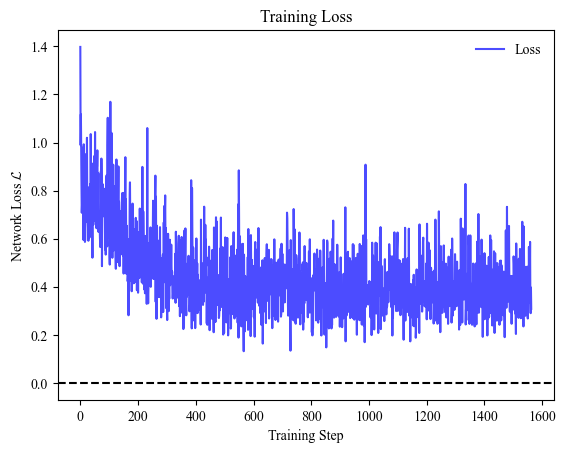

Model Parameters:

Name: non_linear_activ.0.weight
Shape: torch.Size([2, 2])
Values: tensor([[-0.5700, -0.6956],
        [-0.6956, -0.5700]])
Name: non_linear_activ.2.weight
Shape: torch.Size([1, 2])
Values: tensor([[-0.6100, -0.6100]])


In [45]:
model = oneDNetwork().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)


# train, plot loss
tot_loss = []
tot_steps_loss = []
# tot_param_changes = []
# tot_param_steps = []
loss_step_count = 0

for epoch in range(1):
    loss1_steps, loss1_values, param1_steps, param1_changes = train(trainloader, model, loss_fn, optimizer, track_loss=True, track_params=False, symmetry=True)
    # param1_steps = [x + loss_step_count for x in param1_steps]
    loss1_steps = [x + loss_step_count for x in loss1_steps]
    loss_step_count += len(loss1_steps)

    tot_loss.extend(loss1_values)
    tot_steps_loss.extend(loss1_steps)
    # tot_param_changes.extend(param1_changes)
    # tot_param_steps.extend(param1_steps)





# ONLY FOR RELU EXPERIMENTS
# Check for dead neurons
dead_info = check_dead_neurons(model, trainloader)

# Extract per-neuron zero output fraction (for the single nonlinear layer)
# Assuming only one nonlinear layer, so we just grab its first entry
dead_layer_key = list(dead_info.keys())[0]  # e.g., 'Layer 1'
zero_fractions = dead_info[dead_layer_key]['fractions']  # This is a NumPy array


# Optionally also write the total dead neuron *fraction* (e.g., number dead / total)
n_neurons = len(zero_fractions)
n_dead = len(dead_info[dead_layer_key]["dead_neurons"])
total_dead_frac = n_dead / n_neurons if n_neurons > 0 else 0.0






plt.plot(tot_steps_loss, tot_loss, label='Loss', color='blue', alpha=0.7)
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel("Training Step")
plt.ylabel("Network Loss $\mathcal{L}$")
plt.title("Training Loss")
plt.legend()
plt.show()

# print out model parameters to check
print("Model Parameters:\n")
for name, param in model.named_parameters():
    print(f"Name: {name}")
    print(f"Shape: {param.shape}")
    print(f"Values: {param.data}")

# Save the model weights to a file (e.g., 'model_weights.pth')
model_weights = {name: param.data for name, param in model.named_parameters()}
torch.save(model_weights, 'weights.pth')

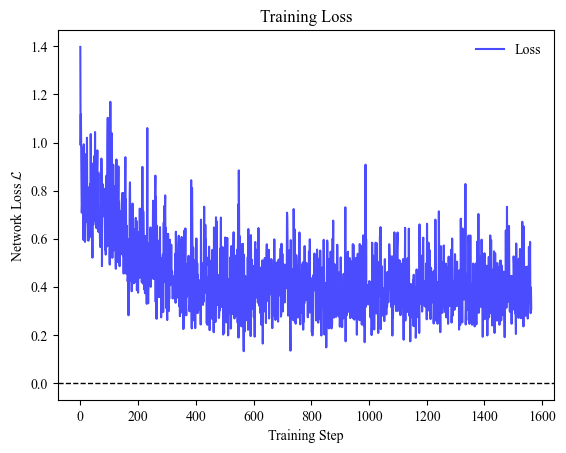

In [53]:
plt.plot(tot_steps_loss, tot_loss, label='Loss', color='blue', alpha=0.7)
plt.axhline(y=0, color='k', linestyle='--', linewidth=1)
plt.xlabel("Training Step")
plt.ylabel("Network Loss $\mathcal{L}$")
plt.title("Training Loss")
plt.legend()
plt.show()

#### Comments

These are asymmetric solutions - not consistent with my analytical results.

Only sometimes does it seem to converge to the expected 'columns same'/'across diagonals' symmetric cases.

# Output Histogram + Overlay

Here we want to compare a histogram of the raw network outputs to an overlaid plot of the propagated theoretical probability density (using Fischer framework).

This functions as a check of the Fischer framework validity.

In [46]:
class shuffled_data(Dataset):
    def __init__(self, inputs, ground_outputs):
        self.samples, self.true_samples = inputs, ground_outputs

    def __len__(self):
        return self.samples.shape[0]

    def __getitem__(self, idx):
        return (
            torch.tensor(self.samples[idx], dtype=torch.float64),
            torch.tensor(self.true_samples[idx], dtype=torch.float64)
        )

# Network output cumulants
def find_network_output_cumulants(data_loader, model_x):

    network_outputs = collect_model_outputs(data_loader, model_x)
    network_cumulants = cumulant_extraction(network_outputs)
    print("\nExtracted Cumulants (of raw network output):")
    for k, v in network_cumulants.items():
        print(f"{k}: {v}")
    print("\n")
    
    return network_outputs, network_cumulants

def find_netout_cumulants_shuffled(data_loader, model_x, get_iterated=False):

    network_outputs = collect_model_outputs(data_loader, model_x)
    network_cumulants = cumulant_extraction(network_outputs)
    print("\nExtracted Cumulants (of raw network output):")
    for k, v in network_cumulants.items():
        print(f"{k}: {v}")
    print("\n")

    if get_iterated:
        shufffled_outputs = np.random.permutation(network_outputs)  # Shuffle the outputs
        new_inputs = np.column_stack((network_outputs, shufffled_outputs))  # Shape: (N, 2)
        decimated_outputs = np.sum(new_inputs, axis=1) / np.sqrt(2)  # Shape: (N,)
        
        iterated_data = shuffled_data(new_inputs, decimated_outputs)
    
    return network_outputs, network_cumulants, iterated_data

def extract_weights(model):
    weights = []
    biases = []
    
    for layer in model.non_linear_activ:
        if isinstance(layer, nn.Linear):
            W = layer.weight.detach().cpu().numpy()
            weights.append(torch.tensor(W, dtype=torch.float64))
            if layer.bias is not None:
                b = layer.bias.detach().cpu().numpy()
                biases.append(torch.tensor(b, dtype=torch.float64))
    
    return weights, biases

def JL_cumulant_evolution(data, num_iterations):
    """ Input: data is a dictionary of cumulants, num_iterations is the number of iterations to perform.
        Output: a dictionary of cumulants after num_iterations iterations.
        
        The functions scales each nth order cumulant by the appropriate factor for the number of iterations.
        
        Was num_iterations + 1 (previous version of code), have now changed it to just num_iterations."""
    
    scaled_cumulants = {}
    for key, value in data.items():
        # Extract the cumulant order (k) from the key string 'kappa{k}'
        k = int(key[-1])
        
        # Calculate the scaling factor
        scaling_factor = 2 ** (1 - k / 2)
        
        # Scale the cumulant value num_iterations times
        scaled_cumulants[key] = value * (scaling_factor ** (num_iterations))
    
    return scaled_cumulants


In [47]:
import math
from scipy.interpolate import interp1d

def pdf_from_cumulants(y_vals, cumulants, t_max=50.0, num_points=2**12, plot=False):
    """
    Construct a PDF from a list of cumulants using characteristic function inversion.

    Args:
        y_vals (np.ndarray): Points at which to evaluate the PDF.
        cumulants (list): List of raw cumulants (may include PyTorch tensors).
        t_max (float): Max frequency for integration.
        num_points (int): Number of FFT points (preferably power of 2).

    Returns:
        np.ndarray: Approximated PDF values.
    """
    t = np.linspace(-t_max, t_max, num_points)
    dt = t[1] - t[0]

    log_phi = np.zeros_like(t, dtype=np.complex128)

    for n, kappa in enumerate(cumulants, start=1):
        if hasattr(kappa, 'item'):  # Convert PyTorch tensor to scalar
            kappa = kappa.item()
        log_phi += (1j * t)**n * kappa / math.factorial(n)

    log_phi = np.clip(np.real(log_phi), -500, 500) + 1j * np.imag(log_phi)
    phi = np.exp(log_phi)

    # # phase correct
    # mean = cumulants[0]
    # phi *= np.exp(-1j * mean * t)

    # Inverse Fourier transform
    freqs = np.fft.fftfreq(num_points, d=dt)
    y_grid = np.fft.fftshift(freqs) * 2 * np.pi

    # y_grid = np.linspace(-np.pi / dt, np.pi / dt, num_points)
    fft_pdf = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(phi))) * dt / (2 * np.pi)

    # # Interpolate onto desired y_vals
    # interp_pdf = np.interp(y_vals, y_grid, np.real(fft_pdf))

    # Smooth interpolation
    interpolator = interp1d(y_grid, np.real(fft_pdf), kind='cubic', fill_value='extrapolate')
    interp_pdf = interpolator(y_vals)

    # Normalize
    interp_pdf /= np.trapezoid(interp_pdf, y_vals)

    if plot:
        plt.figure(figsize=(8, 4))
        plt.plot(t, np.abs(phi), label='mod phi')
        plt.axvline(t_max, color='r', linestyle='--', label='t_max')
        plt.title('Magnitude of characteristic function')
        plt.legend()
        plt.grid()
        plt.show()

    return interp_pdf

def theoretical_pdf_normal(y_vals, mu, cov):
    """  
    Plot Theoretical Probability Density Function using a single 1D mean and variance.
    
    Args:
    - y_vals (np.ndarray): Array of y values where the PDF is evaluated.
    - mu (torch.Tensor): Scalar tensor representing the mean.
    - cov (torch.Tensor): Scalar tensor representing the variance.
    
    Returns:
    - pdf (np.ndarray): Theoretical probability density function values.
    """
    # Convert tensors to numpy scalars
    mu = mu.item()
    variance = cov.item()
    sigma = variance ** 0.5  # Convert variance to standard deviation

    # Compute the PDF using the normal distribution
    pdf = norm.pdf(y_vals, loc=mu, scale=sigma)

    # Normalize the PDF so it integrates to 1
    pdf /= np.trapezoid(pdf, y_vals)

    return pdf

# def theoretical_pdf_higher(y_vals, k1, k2, k3, k4):
    """  
    Plot Theoretical PDF using the first four cumulants via Edgeworth expansion.
    
    Args:
    - y_vals (np.ndarray): Points at which to evaluate the PDF.
    - k1 (torch.Tensor): First cumulant (mean).
    - k2 (torch.Tensor): Second cumulant (variance).
    - k3 (torch.Tensor): Third cumulant.
    - k4 (torch.Tensor): Fourth cumulant.
    
    Returns:
    - pdf (np.ndarray): Approximated PDF values.
    """
    # Convert to scalars
    mu = k1.item()
    var = k2.item()
    c3 = k3.item()
    c4 = k4.item()
    
    sigma = np.sqrt(var)
    z = (y_vals - mu) / sigma
    
    # Standard normal PDF
    phi = norm.pdf(z)
    
    # Hermite polynomials
    H3 = hermite(3)(z)
    H4 = hermite(4)(z)

    # Edgeworth correction using raw cumulants
    skew_term = (c3 / (6 * sigma**3)) * H3
    kurt_term = (c4 / (24 * sigma**4)) * H4
    edgeworth_corr = 1 + skew_term + kurt_term

    pdf = phi * edgeworth_corr / sigma  # De-standardize

    # Normalize to integrate to 1
    pdf /= np.trapezoid(pdf, y_vals)

    pdf = np.clip(pdf, 0, None)

    return pdf


In [48]:
from scipy.special import rel_entr  # element-wise P * log(P / Q)

def norm_kl_div_histtopdf(samples, pdf_vals, y_vals):
    """
    Compute normalized KL divergence: D_KL(P_emp || P_theo) / H(P_emp), normalising by the Shannon entropy.

    Use y_vals as pdf evaluation points = bin centres, convert to bin edges.
    Converts density into discrete probability mass function (PMF) using histogram.
    Normalises the PMF to ensure it sums to 1.
    Clipping to avoid log(0) and other numerical issues.

    KL divergence is outputted in units of nats, but this isn't a physical unit, rather a measure of relative information between distributions.
        This normalised KL divergence is unitless, and ranges from 0 to 1.
    0 = perfect match, 1 = divergence as large as the entropy. """

    # Step 1: Histogram
    dy = y_vals[1] - y_vals[0]  # spacing between points
    bin_edges = np.linspace(y_vals[0] - dy / 2, y_vals[-1] + dy / 2, len(y_vals) + 1) # ensures that distribs are defined over matching bins (diff histogram to the previous plots with bin=100)

    hist, bin_edges = np.histogram(samples, bins=bin_edges, density=True)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    bin_widths = np.diff(bin_edges)

    # Empirical PMF
    p_empirical = hist * bin_widths

    # Interpolate theoretical PDF to match bin centers
    pdf_interp = np.interp(bin_centers, y_vals, pdf_vals)
    p_theoretical = pdf_interp * bin_widths
    p_theoretical /= np.sum(p_theoretical)

    # Clip to avoid numerical issues
    eps = 1e-12
    p_empirical = np.clip(p_empirical, eps, 1)
    p_theoretical = np.clip(p_theoretical, eps, 1)

    # KL divergence and entropy
    kl = np.sum(rel_entr(p_empirical, p_theoretical))
    entropy = -np.sum(p_empirical * np.log(p_empirical))

    normalized_kl = kl / entropy
    return normalized_kl

def norm_kl_div_pdf2pdf(p_vals, q_vals, y_vals, eps=1e-12):
    """
    Compute normalized KL divergence: D_KL(P || Q) / H(P)

    Args:
        p_vals (np.ndarray): First PDF values (e.g., empirical).
        q_vals (np.ndarray): Second PDF values (e.g., theoretical).
        y_vals (np.ndarray): Evaluation points (must be evenly spaced).
        eps (float): Small value to avoid log(0) or division by zero.

    Returns:
        float: Normalized KL divergence (unitless, range 0–1)
    """
    dy = y_vals[1] - y_vals[0]

    # Clip PDFs to avoid log(0) or division by 0
    p_safe = np.clip(p_vals, eps, 1)
    q_safe = np.clip(q_vals, eps, 1)

    # KL divergence and entropy (discretized)
    kl = np.sum(rel_entr(p_safe, q_safe)) * dy
    entropy = -np.sum(p_safe * np.log(p_safe)) * dy

    normalized_kl = kl / entropy
    return normalized_kl


In [49]:
from scipy.stats import wasserstein_distance

def wasserstein_histtopdf(samples, pdf_vals, y_vals):
    """
    Compute Wasserstein distance between empirical samples and a theoretical PDF evaluated on y_vals.

    Args:
        samples (np.ndarray): Empirical samples.
        pdf_vals (np.ndarray): Theoretical PDF values (must match y_vals).
        y_vals (np.ndarray): Points at which PDF is evaluated (assumed evenly spaced).

    Returns:
        float: Wasserstein distance (same units as y_vals)
    """
    dy = y_vals[1] - y_vals[0]

    # Create a sample-based approximation of the PDF (discrete measure)
    theoretical_mass = pdf_vals * dy
    theoretical_mass /= np.sum(theoretical_mass)  # normalize to sum to 1

    # Treat y_vals as support and theoretical_mass as weights
    return wasserstein_distance(u_values=samples, v_values=y_vals, v_weights=theoretical_mass)

def wasserstein_pdf2pdf(p_vals, q_vals, y_vals):
    """
    Compute Wasserstein distance between two PDFs evaluated on a shared grid.

    Args:
        p_vals (np.ndarray): PDF 1 (e.g., empirical).
        q_vals (np.ndarray): PDF 2 (e.g., theoretical).
        y_vals (np.ndarray): Evaluation points (assumed evenly spaced).

    Returns:
        float: Wasserstein distance
    """
    dy = y_vals[1] - y_vals[0]

    # Normalize both PDFs to sum to 1
    p_mass = p_vals * dy
    q_mass = q_vals * dy
    p_mass /= np.sum(p_mass)
    q_mass /= np.sum(q_mass)

    return wasserstein_distance(u_values=y_vals, v_values=y_vals, u_weights=p_mass, v_weights=q_mass)



### Propagate Cumulants

In [50]:
# First extract weights and biases from the model
weights, biases = extract_weights(model)
print(f"{len(weights)}, {len(biases)}")
print(f"weights: {weights}")
print(f"biases: {biases}")

input_samples, input_loader = test_samples, testloader
JL_test_samples = test_samples
num_iterations = 10

# As a check compare the expected JL evolution of cumulants after num_iterations
avg_initial_cumulants, _ = find_input_cumulants(JL_test_samples)
predicted_cumulants = JL_cumulant_evolution(avg_initial_cumulants, num_iterations)
print("\n~~~Here's a check that I've done it right!~~~~:\nPredicted Cumulants (after all iterations):")
for k, v in predicted_cumulants.items():
    print(f"{k}: {v}")

for number in range(num_iterations):

    # region
    #############
    # Find and save the JL prediction cumulants after this num_iterations
    #############
    JL_number = number + 1
    JL_expected_c = JL_cumulant_evolution(avg_initial_cumulants, JL_number)

    # endregion

    # region
    #############
    # Cumulant extraction, get next dataset
    #############

    # print(f"\nExpected cumulants for uniform distribution: \n {1/2}, {1/12}, {0}, {-1/120}")  # Expected cumulants for uniform distribution
    avg_input_c, z_dict = find_input_cumulants(input_samples)
    avg_jl_cumulants, ground_truth_c = find_pred_output_cumulants(input_samples)
    network_outputs, network_cumulants, next_iteration_data_samples = find_netout_cumulants_shuffled(input_loader, model, get_iterated=True)

    # Redefine dataset for next iteration
    input_samples = next_iteration_data_samples
    input_loader = DataLoader(input_samples, batch_size=64, shuffle=False)
    


    # # Propagate cumulants

    # # Networks with nonlinearity
    # mu_out, cov_out = propagate_full_gaussian_only(z_dict, weights, biases=None) # if using biases, set biases = True
    # cumulants_plotting = [mu_out, cov_out]

    # # # Networks without nonlinearity
    # # mu_out, cov_out, g3_out, g4_out = propagate_full_linear(z_dict, weights, biases=None) # if using biases, set biases = True
    # # cumulants_plotting = [mu_out, cov_out, g3_out, g4_out]

    # print("\n\n------------\nPropagation complete. Propagated cumulants:")
    # print(f" mean: {mu_out} \n cov: {cov_out}\n")
    # # print(f" g3: {g3_out} \n g4: {g4_out}\n") # include if using higher cumulants




    # endregion
    
    # region
    ###############
    # Plot this iteration
    ###############

    y_vals = np.linspace(np.min(network_outputs), np.max(network_outputs), 500)

    # # Find the pdf using propagated cumulants
    # pdf_truncated_propagated = theoretical_pdf_normal(y_vals, mu_out, cov_out)
    # pdf_higher_propagated = pdf_from_cumulants(y_vals, cumulants_plotting, t_max=80, num_points=2**13, plot=True)

    plot_histogram(network_outputs, bins=100, color='orange', show=True, norm=True, edgecolor='none')

    # # Plot with both overlaid
    # plot_histogram(network_outputs, bins=100, color='orange', show=False, norm=True)
    # plt.plot(y_vals, pdf_truncated_propagated, label="Gaussian", color='black', linewidth=2)
    # plt.plot(y_vals, pdf_higher_propagated, label="With $\kappa_{3}, \kappa_{4}$", color='blue', linewidth=2)

    # # plt.title("Empirical Data vs Theoretical PDF")
    # plt.xlabel("Network Output $y$")
    # plt.ylabel("Probability Density $p(y)$")
    # plt.legend(fontsize=9)
    # plt.show()


    # # Plot with just truncated
    # plot_histogram(network_outputs, bins=100, color='orange', show=False, norm=True)
    # plt.plot(y_vals, pdf_truncated_propagated, label="Gaussian", color='black', linewidth=2)
    # plt.xlabel("Network Output $y$")
    # plt.ylabel("Probability Density $p(y)$")
    # plt.legend(fontsize=9)
    # plt.show()

    # # Plot with just higher
    # plot_histogram(network_outputs, bins=100, color='orange', show=False, norm=True)
    # plt.plot(y_vals, pdf_higher_propagated, label="With $\kappa_{3}, \kappa_{4}$", color='blue', linewidth=2)
    # # plt.axvline(x=cumulants_plotting[0], color='red', linestyle='--', label='Mean')
    # plt.xlabel("Network Output $y$")
    # plt.ylabel("Probability Density $p(y)$")
    # plt.legend(fontsize=9)
    # plt.show()



    # endregion

    # region
    ##################
    # Consistency with analytical results
    ##################

    # layer1, layer2 = weights[0], weights[1]
    # w0, w1, w2, w3 = layer1[0, 0], layer1[0, 1], layer1[1, 0], layer1[1, 1]
    # a0, a1 = layer2[0, 0], layer2[0, 1]

    # if biases:
    #     biases1, biases2 = biases[0], biases[1]
    #     b0, b1 = biases1[0], biases1[1]
    #     b2 = biases2[0]

    # w0_save = w0.item()
    # s2_2a0_w1 = np.sqrt(2)/(2 * a0) - w1
    # s2_2a0_w1 = s2_2a0_w1.item()

    # print(f"w0: {w0_save}, sqrt(2)/2a0 - w1: {s2_2a0_w1}")
    # if biases:
    #     print(f"b2: {b2}, -2*a0*b1: {-2 * a0 * b1}")

    # endregion

    # region
    ###################
    # KL divergence
    ###################

    # Ground truth
    gt_cumulants_list_linear = [ground_truth_c['kappa1'], ground_truth_c['kappa2'], ground_truth_c['kappa3'], ground_truth_c['kappa4']]
    gt_pdf_trunc = theoretical_pdf_normal(y_vals, ground_truth_c['kappa1'], ground_truth_c['kappa2'])
    gt_pdf_higher = pdf_from_cumulants(y_vals, gt_cumulants_list_linear, t_max=80, num_points=2**13)

    # JL predictions
    jl_cumulants_list_linear = [avg_jl_cumulants['kappa1'], avg_jl_cumulants['kappa2'], avg_jl_cumulants['kappa3'], avg_jl_cumulants['kappa4']]
    jl_pdf_trunc = theoretical_pdf_normal(y_vals, avg_jl_cumulants['kappa1'], avg_jl_cumulants['kappa2'])
    jl_pdf_higher = pdf_from_cumulants(y_vals, jl_cumulants_list_linear, t_max=80, num_points=2**13)


    # Find KL divergences

    # network output/ground truth
    kl_netout_gt_trunc = norm_kl_div_histtopdf(network_outputs, gt_pdf_trunc, y_vals)
    kl_netout_gt_higher = norm_kl_div_histtopdf(network_outputs, gt_pdf_higher, y_vals)

    # # propagated/ground truth
    # kl_propagated_gt_trunc = norm_kl_div_pdf2pdf(pdf_truncated_propagated, gt_pdf_trunc, y_vals)
    # kl_propagated_gt_higher = norm_kl_div_pdf2pdf(pdf_higher_propagated, gt_pdf_higher, y_vals)

    # # network output/propagated
    # kl_netout_propagated_trunc = norm_kl_div_histtopdf(network_outputs, pdf_truncated_propagated, y_vals)
    # kl_netout_propagated_higher = norm_kl_div_histtopdf(network_outputs, pdf_higher_propagated, y_vals)

    # JL predictions/ground truth
    kl_jl_gt_trunc = norm_kl_div_pdf2pdf(jl_pdf_trunc, gt_pdf_trunc, y_vals)
    kl_jl_gt_higher = norm_kl_div_pdf2pdf(jl_pdf_higher, gt_pdf_higher, y_vals)

    # network output/JL predictions
    kl_netout_jl_trunc = norm_kl_div_histtopdf(network_outputs, jl_pdf_trunc, y_vals)
    kl_netout_jl_higher = norm_kl_div_histtopdf(network_outputs, jl_pdf_higher, y_vals)


    # endregion

    # region
    ##################
    # Wasserstein distance
    ##################

    # Find the distances

    # network output/ground truth
    wd_netout_gt_trunc = norm_kl_div_histtopdf(network_outputs, gt_pdf_trunc, y_vals)
    wd_netout_gt_higher = norm_kl_div_histtopdf(network_outputs, gt_pdf_higher, y_vals)

    # # propagated/ground truth
    # wd_propagated_gt_trunc = norm_kl_div_pdf2pdf(pdf_truncated_propagated, gt_pdf_trunc, y_vals)
    # wd_propagated_gt_higher = norm_kl_div_pdf2pdf(pdf_higher_propagated, gt_pdf_higher, y_vals)

    # # network output/propagated
    # wd_netout_propagated_trunc = norm_kl_div_histtopdf(network_outputs, pdf_truncated_propagated, y_vals)
    # wd_netout_propagated_higher = norm_kl_div_histtopdf(network_outputs, pdf_higher_propagated, y_vals)

    # JL predictions/ground truth
    wd_jl_gt_trunc = norm_kl_div_pdf2pdf(jl_pdf_trunc, gt_pdf_trunc, y_vals)
    wd_jl_gt_higher = norm_kl_div_pdf2pdf(jl_pdf_higher, gt_pdf_higher, y_vals)

    # network output/JL predictions
    wd_netout_jl_trunc = norm_kl_div_histtopdf(network_outputs, jl_pdf_trunc, y_vals)
    wd_netout_jl_higher = norm_kl_div_histtopdf(network_outputs, jl_pdf_higher, y_vals)




    # endregion

    # region
    ####################
    # Save to excel file
    #####################

    def find_next_empty_row(ws, anchor_col=2):
        row = 6
        while ws.cell(row=row, column=anchor_col).value is not None:
            row += 1
        return row

    # Load your workbook and sheet
    # wb = load_workbook(r"C:\Users\cassi\Documents\Cambridge\III\Project\Results\uniform task.xlsx")
    ws = wb["0.1 LR symm"]  # or the exact name of your sheet

    # Example: write raw cumulants starting at column H (8), row 3
    # start_row = 12
    start_row = find_next_empty_row(ws)
    start_col = 2 #(B)
    cumulant_start_column = 7
    KL_start_column = 27
    wass_start_column = 38
    dead_start_column = 49
    real_number = number + 1

    ws.cell(row=start_row, column=start_col, value=real_number)
    ws.cell(row=start_row, column=start_col - 1, value=SEED)
    ws.cell(row=start_row, column=cumulant_start_column - 1, value=slope)

    # ws.cell(row=start_row, column=start_col + 1, value=w0_save)
    # ws.cell(row=start_row, column=start_col + 2, value=s2_2a0_w1)

    # Write average input cumulants (1st row)
    for i, val in enumerate(avg_input_c.values()):
        ws.cell(row=start_row, column=cumulant_start_column + i, value=float(val))

    # Write JL prediction cumulants
    for i, val in enumerate(avg_jl_cumulants.values()):
        ws.cell(row=start_row, column=cumulant_start_column + 4 + i, value=float(val))

    # Write empirical cumulants
    for i, val in enumerate(network_cumulants.values()):
        ws.cell(row=start_row, column=cumulant_start_column + 8 + i, value=float(val))

    # # Write propagated cumulants
    # for i, val in enumerate(cumulants_plotting):
    #     ws.cell(row=start_row, column=cumulant_start_column + 12 + i, value=float(val))

    # Write ground truth cumulants
    for i, val in enumerate(ground_truth_c.values()):
        ws.cell(row=start_row, column=cumulant_start_column + 16 + i, value=float(val))


    ws.cell(row=start_row, column=KL_start_column, value=kl_netout_gt_trunc)
    ws.cell(row=start_row, column=KL_start_column+1, value=kl_netout_gt_higher)

    # ws.cell(row=start_row, column=KL_start_column+2, value=kl_propagated_gt_trunc)
    # ws.cell(row=start_row, column=KL_start_column+3, value=kl_propagated_gt_higher)

    # ws.cell(row=start_row, column=KL_start_column+4, value=kl_netout_propagated_trunc)
    # ws.cell(row=start_row, column=KL_start_column+5, value=kl_netout_propagated_higher)

    ws.cell(row=start_row, column=KL_start_column+6, value=kl_jl_gt_trunc)
    ws.cell(row=start_row, column=KL_start_column+7, value=kl_jl_gt_higher)

    ws.cell(row=start_row, column=KL_start_column+8, value=kl_netout_jl_trunc)
    ws.cell(row=start_row, column=KL_start_column+9, value=kl_netout_jl_higher)



    # Write wasserstein distances
    ws.cell(row=start_row, column=wass_start_column, value=wd_netout_gt_trunc)
    ws.cell(row=start_row, column=wass_start_column+1, value=wd_netout_gt_higher)

    # ws.cell(row=start_row, column=wass_start_column+2, value=wd_propagated_gt_trunc)
    # ws.cell(row=start_row, column=wass_start_column+3, value=wd_propagated_gt_higher)

    # ws.cell(row=start_row, column=wass_start_column+4, value=wd_netout_propagated_trunc)
    # ws.cell(row=start_row, column=wass_start_column+5, value=wd_netout_propagated_higher)

    ws.cell(row=start_row, column=wass_start_column+6, value=wd_jl_gt_trunc)
    ws.cell(row=start_row, column=wass_start_column+7, value=wd_jl_gt_higher)

    ws.cell(row=start_row, column=wass_start_column+8, value=wd_netout_jl_trunc)
    ws.cell(row=start_row, column=wass_start_column+9, value=wd_netout_jl_higher)


    # Write each neuron's zero-output fraction to Excel
    for i, frac in enumerate(zero_fractions):
        ws.cell(row=start_row, column=dead_start_column + i, value=frac)

    # Save total as one extra column
    ws.cell(row=start_row, column=dead_start_column + n_neurons, value=total_dead_frac)


    # Save expected JL values (from inputs alone) after number iterations
    for i, val in enumerate(JL_expected_c.values()):
        ws.cell(row=start_row, column=dead_start_column + 4 + i, value=float(val))


    # Save workbook
    wb.save(r"C:\Users\cassi\Documents\Cambridge\III\Project\Results\uniform task.xlsx")
    # endregion

2, 0
weights: [tensor([[-0.5700, -0.6956],
        [-0.6956, -0.5700]]), tensor([[-0.6100, -0.6100]])]
biases: []


KeyboardInterrupt: 

## Consistency with Analytical Solutions

Reminder:
- 1 linear layer, no biases: $w_{0} = w_{1} = \frac{1}{\sqrt{2}}$
- 1 linear layer, with biases: same as above, with $b = 0$
- 2 linear layers, no biases: $w_{0} = \frac{\sqrt{2}}{2a_{0}} - w_{1}$
- 2 linear layers, with biases: $b_{2} = -2a_{0}b_{1}, \; w_{0} = \frac{1}{a_{0}\sqrt(2)} - w_{1}$